In [1]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
import utils
import transformer

In [10]:
STYLE_MODEL_PATH = "transforms/wave.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_improved_mask(image: Image.Image, target_object="foreground"):
    """Generate better mask using multiple segmentation approaches"""
    # 1. Try DeepLabV3+ instead of regular DeepLabV3
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).to(DEVICE).eval()
    
    # Ensure image is RGB
    image = image.convert("RGB")
    image_np = np.array(image)
    
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(input_tensor)['out']
    
    # Get all class predictions
    prediction = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    
    # 2. Try GrabCut as a backup/enhancement method
    # Create initial mask for GrabCut
    height, width = image_np.shape[:2]
    # Start with a rectangle in the center
    rect = (width//4, height//4, width//2, height//2)
    mask_grabcut = np.zeros((height, width), np.uint8)
    
    # Initialize with likely foreground/background based on DeepLabV3 output
    # Use non-zero predictions as potential foreground
    mask_grabcut[prediction > 0] = cv2.GC_PR_FGD  # probably foreground
    mask_grabcut[prediction == 0] = cv2.GC_PR_BGD  # probably background
    
    # Define foreground and background models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    # Apply GrabCut
    try:
        cv2.grabCut(image_np, mask_grabcut, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)
    except:
        print("[WARNING] GrabCut failed, falling back to DeepLabV3 only")
    
    # Create mask where definite or probable foreground
    grabcut_mask = np.where((mask_grabcut == cv2.GC_FGD) | (mask_grabcut == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    
    # 3. Use color-based segmentation to enhance edges
    # Convert to HSV color space
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    
    # Create a mask that emphasizes potential foreground objects based on saturation
    # (assumes foreground objects are more saturated than background)
    saturation = hsv[:, :, 1]
    sat_threshold = np.percentile(saturation, 60)  # Adaptive threshold
    sat_mask = (saturation > sat_threshold).astype(np.uint8)
    
    # 4. Combine masks (DeepLabV3 + GrabCut + Saturation)
    # Take the union of DeepLabV3 and GrabCut masks
    # Add objects with high saturation
    combined_mask = np.zeros_like(grabcut_mask)
    
    # Pick based on target
    if target_object == "foreground":
        # For foreground objects (like statues, people), use a combination
        # Start with DeepLabV3 predictions for classes 15-25 (common foreground objects)
        deeplab_fg_mask = np.zeros_like(prediction)
        for class_id in range(15, 25):  # Person, vehicles, animals, etc.
            deeplab_fg_mask = np.logical_or(deeplab_fg_mask, prediction == class_id)
        
        # Combine masks with OR operation
        combined_mask = np.logical_or(deeplab_fg_mask, grabcut_mask).astype(np.uint8)
        # Further refine with saturation where appropriate
        combined_mask = np.logical_or(combined_mask, 
                                      np.logical_and(sat_mask, grabcut_mask)).astype(np.uint8)
    else:
        # For background preservation, invert the logic
        combined_mask = np.logical_not(
            np.logical_or(grabcut_mask, 
                          np.logical_and(sat_mask, grabcut_mask))
        ).astype(np.uint8)
    
    # 5. Post-process the mask
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    
    # 6. Find the largest contour (assumed to be the main object)
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Keep only the largest contour or largest few contours
        mask_largest = np.zeros_like(combined_mask)
        
        # Take up to 3 largest contours that are at least 5% of the largest one
        largest_area = cv2.contourArea(contours[0])
        min_area_threshold = largest_area * 0.05
        
        contour_count = 0
        for contour in contours:
            if cv2.contourArea(contour) >= min_area_threshold and contour_count < 3:
                cv2.drawContours(mask_largest, [contour], 0, 1, -1)
                contour_count += 1
        
        # Use the refined mask
        final_mask = mask_largest
    else:
        # Fallback to combined mask if no contours found
        final_mask = combined_mask
    
    # Finally, smooth the mask for better blending
    final_mask = cv2.GaussianBlur(final_mask.astype(float), (9, 9), sigmaX=3)
    
    # Return as PIL Image
    return Image.fromarray((final_mask * 255).astype(np.uint8)).convert("L")

In [4]:
def stylize_with_preservation(content_path, output_path, preserve="foreground", style_strength=1.0):
    """
    Apply style transfer with object preservation
    preserve: "foreground" or "background" - which part to preserve
    style_strength: 0.0-1.0 - how strong the style should be applied
    """
    print("[INFO] Loading content image...")
    # Load image directly as PIL to preserve exact colors
    content_pil = Image.open(content_path).convert("RGB")
    content_np = np.array(content_pil)
    
    # Make a copy for style transfer that matches utils.load_image expectations
    content_image = utils.load_image(content_path)
    
    w, h = content_pil.size
    
    print(f"[INFO] Generating mask to preserve {preserve}...")
    raw_mask = get_improved_mask(content_pil, target_object=preserve)
    
    # Resize mask to match content image dimensions
    raw_mask = raw_mask.resize((w, h), Image.LANCZOS)
    
    # Convert mask to numpy (0-1 range)
    mask_np = np.array(raw_mask) / 255.0
    
    # Visualize mask
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(content_pil)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f"{preserve.capitalize()} Mask (White = Preserve)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("[INFO] Loading style model...")
    net = transformer.TransformerNetwork()
    net.load_state_dict(torch.load(STYLE_MODEL_PATH, map_location=DEVICE))
    net = net.to(DEVICE).eval()
    
    print("[INFO] Stylizing image...")
    content_tensor = utils.itot(content_image).to(DEVICE)
    
    with torch.no_grad():
        stylized_tensor = net(content_tensor)
    
    stylized_image = utils.ttoi(stylized_tensor.cpu())
    stylized_np = np.array(stylized_image)
    
    # Make sure arrays match in dimensions
    if content_np.shape != stylized_np.shape:
        content_np = cv2.resize(content_np, (stylized_np.shape[1], stylized_np.shape[0]))
    
    # Expand mask to 3 channels for RGB blending
    mask_3ch = np.stack([mask_np] * 3, axis=2)
    
    # Make sure mask dimensions match image dimensions
    if mask_3ch.shape[:2] != stylized_np.shape[:2]:
        mask_3ch = cv2.resize(mask_3ch, (stylized_np.shape[1], stylized_np.shape[0]))
    
    # Apply style strength adjustment
    if style_strength < 1.0:
        # Blend stylized with original based on strength
        stylized_np = stylized_np * style_strength + content_np * (1 - style_strength)
    
    # Blend based on preservation target
    if preserve == "foreground":
        # mask_3ch is 1 where foreground is (preserve foreground)
        blended_np = (content_np * mask_3ch) + (stylized_np * (1 - mask_3ch))
    else:
        # mask_3ch is 1 where background is (preserve background)
        blended_np = (content_np * (1 - mask_3ch)) + (stylized_np * mask_3ch)
    
    blended_np = np.clip(blended_np, 0, 255).astype(np.uint8)
    
    # Show result
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(content_np)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(stylized_np)
    plt.title("Fully Stylized")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(blended_np)
    plt.title("Semantic Blended Result")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    result = Image.fromarray(blended_np)
    result.save(output_path)
    print(f"[INFO] Saved semantic-stylized result to {output_path}")
    return result

[INFO] Loading content image...
[INFO] Generating mask to preserve foreground...


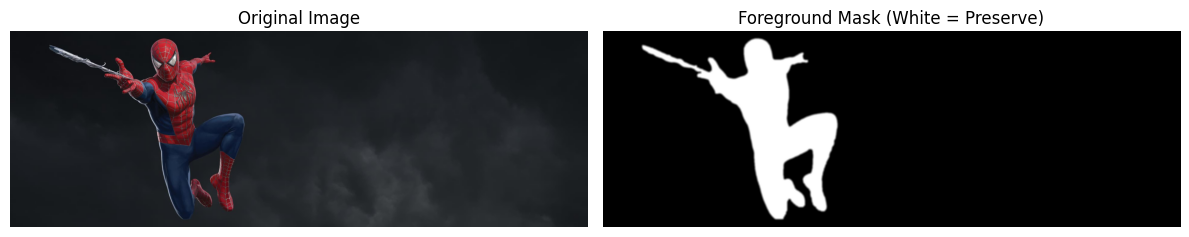

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-481.51128540039065..762.6876831054688].


[INFO] Loading style model...
[INFO] Stylizing image...


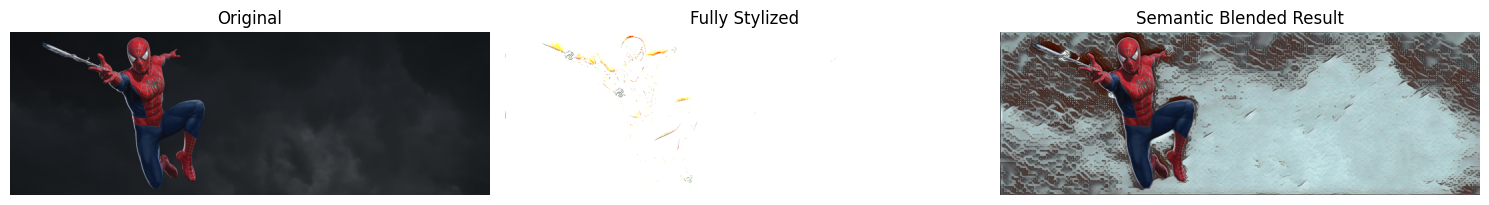

[INFO] Saved semantic-stylized result to images/results/semantic_stylized_spiderman_waves1.png


In [11]:
if __name__ == "__main__":
    # For Statue of Liberty or similar monuments
    stylize_with_preservation(
        "images/input/spiderman.png", 
        "images/results/semantic_stylized_spiderman_waves1.png", 
        preserve="foreground",  # Preserve the statue, style the background
        style_strength=0.8  # Slightly reduce style intensity
    )